## 统计每个地区的人数

In [1]:
import pandas as pd
import os

# 获取当前 Notebook 所在目录（即工作目录）
script_dir = os.getcwd()

# 原始评论数据文件路径（固定路径）
file_path = '/Users/elsa/Desktop/爬虫学习/0702学习/黄浦江评论.xlsx'

# 读取评论数据
df = pd.read_excel(file_path)

# 检查“评论地区”列是否存在
if '评论地区' not in df.columns:
    raise ValueError("Excel 文件中未找到 '评论地区' 这一列，请检查列名是否正确。")

# 统计每个地区的评论人数
region_counts = df['评论地区'].value_counts().reset_index()
region_counts.columns = ['评论地区', '人数']

# 构造保存路径：保存到 notebook 所在文件夹下
output_path = os.path.join(script_dir, '黄浦江评论地区统计.xlsx')

# 保存为 Excel
region_counts.to_excel(output_path, index=False)

print(f"统计结果已保存至: {output_path}")


统计结果已保存至: /Users/elsa/Desktop/爬虫学习/0703学习/黄浦江评论地区统计.xlsx


<ipython-input-1-cb0882b360d0>:25: UserWarning: Pandas requires version '1.4.3' or newer of 'xlsxwriter' (version '1.3.8' currently installed).
  region_counts.to_excel(output_path, index=False)


## 对评论地区进行大洲/国家/城市的分类

In [6]:
import pandas as pd
import os

# 用绝对路径读取源文件
input_file = '/Users/elsa/Desktop/爬虫学习/0703学习/黄浦江评论地区统计.xlsx'
df = pd.read_excel(input_file)

# 中国省份
china_provinces = [
    '北京', '天津', '上海', '重庆', '河北', '山西', '辽宁', '吉林', '黑龙江', '江苏', '浙江',
    '安徽', '福建', '江西', '山东', '河南', '湖北', '湖南', '广东', '海南', '四川', '贵州',
    '云南', '陕西', '甘肃', '青海', '内蒙古', '广西', '西藏', '宁夏', '新疆', '香港', '澳门', '台湾'
]

# 美国州（中文）
us_states_cn = [
    '阿拉巴马', '阿拉斯加', '亚利桑那', '阿肯色', '加利福尼亚', '科罗拉多', '康涅狄格', '特拉华', '佛罗里达',
    '佐治亚', '夏威夷', '爱达荷', '伊利诺伊', '印第安纳', '爱荷华', '堪萨斯', '肯塔基', '路易斯安那',
    '缅因', '马里兰', '马萨诸塞', '密歇根', '明尼苏达', '密西西比', '密苏里', '蒙大拿', '内布拉斯加',
    '内华达', '新罕布什尔', '新泽西', '新墨西哥', '纽约', '北卡罗来纳', '北达科他', '俄亥俄', '俄克拉荷马',
    '俄勒冈', '宾夕法尼亚', '罗德岛', '南卡罗来纳', '南达科他', '田纳西', '得克萨斯', '犹他', '佛蒙特',
    '弗吉尼亚', '华盛顿', '西弗吉尼亚', '威斯康星', '怀俄明'
]

# 城市 → 国家映射
city_country_fallback = {
    "佛罗伦萨": "意大利",
    "里斯本": "葡萄牙",
    "布宜诺斯艾利斯": "阿根廷",
    "利雅得": "沙特阿拉伯",
    "圣地亚哥": "智利",
    "京都": "日本",
    "曼谷": "泰国"
}

# 国家 → 大洲映射（静态）
continent_map_manual = {
    '中国': '亚洲', '美国': '北美洲', '英国': '欧洲', '法国': '欧洲', '德国': '欧洲', '意大利': '欧洲',
    '西班牙': '欧洲', '日本': '亚洲', '韩国': '亚洲', '泰国': '亚洲', '新加坡': '亚洲', '加拿大': '北美洲',
    '澳大利亚': '大洋洲', '新西兰': '大洋洲', '马来西亚': '亚洲', '印度': '亚洲', 'India': '亚洲',
    '俄罗斯': '欧洲', '越南': '亚洲', '菲律宾': '亚洲', '印尼': '亚洲', '阿联酋': '亚洲',
    '土耳其': '亚洲', '巴西': '南美洲', '南非': '非洲', '瑞士': '欧洲', '荷兰': '欧洲', '比利时': '欧洲',
    '瑞典': '欧洲', '芬兰': '欧洲', '挪威': '欧洲', '丹麦': '欧洲', '墨西哥': '北美洲', '埃及': '非洲',
    '希腊': '欧洲', '奥地利': '欧洲', '爱尔兰': '欧洲', '捷克': '欧洲', '匈牙利': '欧洲', '以色列': '亚洲',
    '葡萄牙': '欧洲', '阿根廷': '南美洲', '沙特阿拉伯': '亚洲', '智利': '南美洲',
    '罗马尼亚': '欧洲', '白俄罗斯': '欧洲', '立陶宛': '欧洲', '摩纳哥': '欧洲',
    '伊朗': '亚洲', '巴基斯坦': '亚洲', '秘鲁': '南美洲', '斯里兰卡': '亚洲'
}

# 拆分函数
def split_region(val):
    if "分享" in val:
        return pd.Series(["未知", "未知"])
    for p in china_provinces:
        if val.startswith(p):
            return pd.Series(["中国", val])
    for s in us_states_cn:
        if val.startswith(s):
            return pd.Series(["美国", val])
    for country in continent_map_manual.keys():
        if val.startswith(country):
            return pd.Series([country, val[len(country):] or country])
    for city, country in city_country_fallback.items():
        if city in val:
            return pd.Series([country, val])
    return pd.Series(["未知", val])

df[['国家', '地区/城市']] = df['评论地区'].apply(split_region)
df['大洲'] = df['国家'].map(continent_map_manual).fillna('未知')

# 汇总分享
share_total = df[(df['国家'] == '未知') & (df['地区/城市'] == '未知')]['人数'].sum()
df = df[~((df['国家'] == '未知') & (df['地区/城市'] == '未知'))]
if share_total > 0:
    df = pd.concat([df, pd.DataFrame([['未知', '未知', '未知', share_total]], columns=['国家', '地区/城市', '大洲', '人数'])], ignore_index=True)

# 输出路径
output_file = '/Users/elsa/Desktop/爬虫学习/0703学习/黄浦江评论地区分列统计_最终增强版.xlsx'
df[['大洲', '国家', '地区/城市', '人数']].to_excel(output_file, index=False)

print("处理完成，文件保存为：", output_file)


处理完成，文件保存为： /Users/elsa/Desktop/爬虫学习/0703学习/黄浦江评论地区分列统计_最终增强版.xlsx


## 人工翻译+校核

In [11]:
import pandas as pd
import os
from googletrans import Translator

# 初始化翻译器
translator = Translator()

# 1. 定义输入文件路径
input_path = '/Users/elsa/Desktop/爬虫学习/0703学习/黄浦江评论地区分列统计_人工修改版.xlsx'

# 2. 获取当前 notebook 脚本所在目录作为输出路径
script_dir = os.getcwd()
output_path = os.path.join(script_dir, '黄浦江评论地区_翻译合并版.xlsx')

# 3. 读取数据
df = pd.read_excel(input_path)

# 检查列是否存在
expected_cols = {'原始地名', '大洲', '国家', '地区/城市', '人数'}
if not expected_cols.issubset(df.columns):
    raise ValueError(f"Excel 文件必须包含以下列：{expected_cols}")

# 4. 翻译【地区/城市】列为中文（使用 Google Translate）
def translate_city(city_name):
    try:
        result = translator.translate(city_name, src='auto', dest='zh-cn')
        return result.text
    except Exception as e:
        print(f"翻译失败：{city_name}，错误：{e}")
        return city_name  # 保留原文

# 逐个翻译（有缓存时不翻译重复内容）
unique_cities = df['地区/城市'].dropna().unique()
translation_dict = {city: translate_city(city) for city in unique_cities}
df['地区/城市_中文'] = df['地区/城市'].map(translation_dict)

# 5. 分组合并：按【大洲】【国家】【地区/城市_中文】，人数求和
grouped_df = (
    df.groupby(['大洲', '国家', '地区/城市_中文'], as_index=False)
      .agg({'人数': 'sum'})
      .sort_values(by='人数', ascending=False)
)

# 6. 保存文件
grouped_df.to_excel(output_path, index=False)
print(f"✅ 已成功处理并保存为：{output_path}")


翻译失败：加利福尼亚洛杉矶，错误：'coroutine' object has no attribute 'text'
翻译失败：纽约州纽约市，错误：'coroutine' object has no attribute 'text'
翻译失败：墨西哥城，错误：'coroutine' object has no attribute 'text'
翻译失败：多伦多，错误：'coroutine' object has no attribute 'text'
翻译失败：加利福尼亚旧金山，错误：'coroutine' object has no attribute 'text'
翻译失败：温哥华，错误：'coroutine' object has no attribute 'text'
翻译失败：卡尔加里，错误：'coroutine' object has no attribute 'text'
翻译失败：加利福尼亚圣地亚哥，错误：'coroutine' object has no attribute 'text'
翻译失败：伊利诺伊州芝加哥，错误：'coroutine' object has no attribute 'text'
翻译失败：亚利桑那凤凰城，错误：'coroutine' object has no attribute 'text'
翻译失败：加拿大，错误：'coroutine' object has no attribute 'text'
翻译失败：蒙特利尔，错误：'coroutine' object has no attribute 'text'
翻译失败：内华达拉斯维加斯，错误：'coroutine' object has no attribute 'text'
翻译失败：佛罗里达劳德代尔堡，错误：'coroutine' object has no attribute 'text'
翻译失败：佛罗里达那不勒斯，错误：'coroutine' object has no attribute 'text'
翻译失败：亚利桑那图森，错误：'coroutine' object has no attribute 'text'
翻译失败：佛罗里达迈阿密，错误：'coroutine' object has no attribute 'text'
翻译失败：马萨诸塞波士

In [6]:
import pandas as pd
import os

# 原始 Excel 文件路径
input_path = '/Users/elsa/Desktop/爬虫学习/0703学习/黄浦江评论地区_翻译合并版.xlsx'

# 输出文件路径（当前 notebook 所在目录）
output_path = os.path.join(os.getcwd(), '黄浦江评论地区分列统计_含国家与大洲统计.xlsx')

# 读取所有 Sheet
xls = pd.read_excel(input_path, sheet_name=None)

# 获取第一个 Sheet（假设是数据主表）
main_sheet_name = list(xls.keys())[0]
df = xls[main_sheet_name]

# 检查必要列
if not {'大洲', '国家', '人数'}.issubset(df.columns):
    raise ValueError("Excel 文件中必须包含 '大洲'、'国家' 和 '人数' 列")

# 1️⃣ 国家统计
country_stats = (
    df.groupby('国家', as_index=False)['人数']
    .sum()
    .sort_values(by='人数', ascending=False)
)

# 2️⃣ 大洲统计
continent_stats = (
    df.groupby('大洲', as_index=False)['人数']
    .sum()
    .sort_values(by='人数', ascending=False)
)

# 写入新的 Excel 文件（含原始内容 + 新两个 Sheet）
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    # 写入所有原 Sheet
    for sheet_name, sheet_df in xls.items():
        sheet_df.to_excel(writer, sheet_name=sheet_name, index=False)
    
    # 写入新增的统计 Sheet
    country_stats.to_excel(writer, sheet_name='按国家统计', index=False)
    continent_stats.to_excel(writer, sheet_name='按大洲统计', index=False)

print(f"✅ 新文件已保存：{output_path}")


✅ 新文件已保存：/Users/elsa/Desktop/爬虫学习/0703学习/黄浦江评论地区分列统计_含国家与大洲统计.xlsx


## 可视化地图表达

/var/folders/74/vvf36t8x5d54mt560fvxnn3r0000gn/T/ipykernel_26298/2575142330.py:38: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids['geometry'] = dissolved.centroid


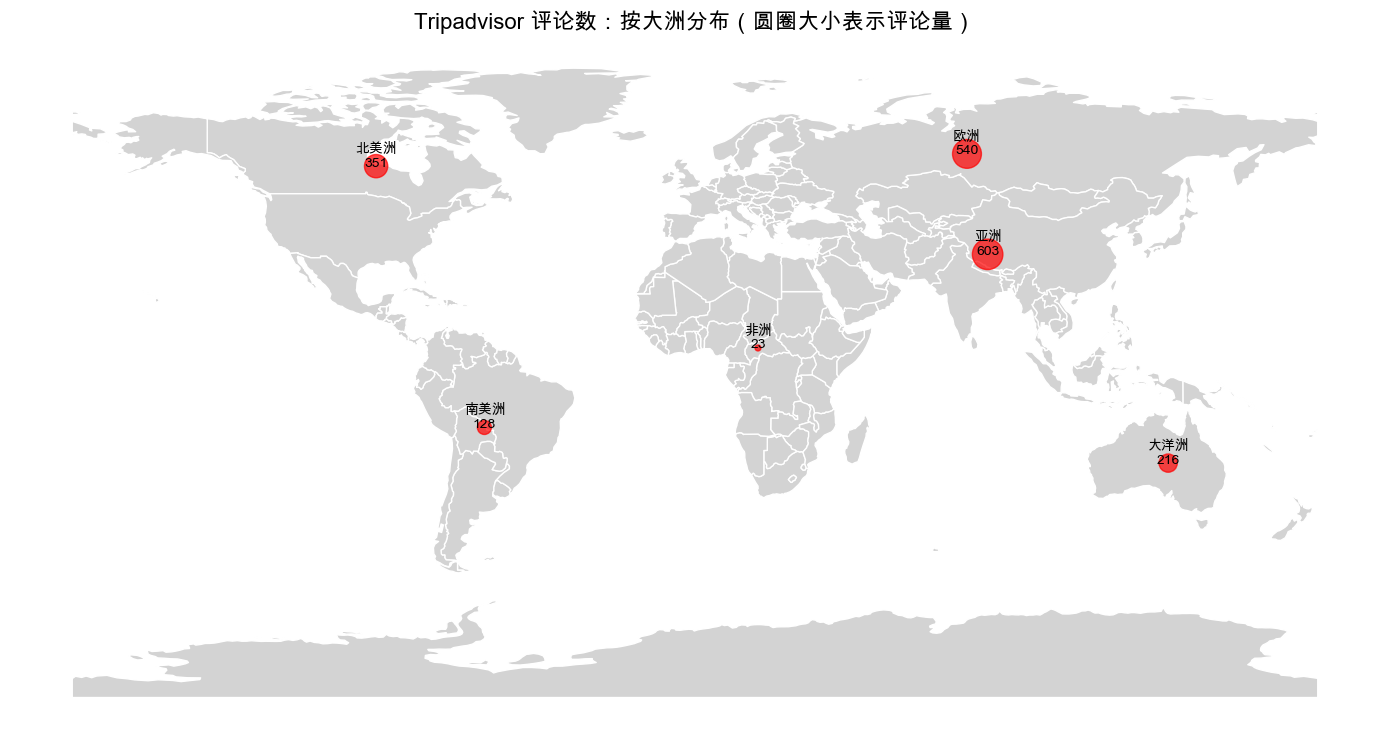

In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False

# 评论数据
continent_comments = {
    "亚洲": 603,
    "欧洲": 540,
    "北美洲": 351,
    "大洋洲": 216,
    "南美洲": 128,
    "非洲": 23
}

# 中英文大洲映射
continent_map = {
    'Asia': '亚洲',
    'Europe': '欧洲',
    'North America': '北美洲',
    'Oceania': '大洋洲',
    'South America': '南美洲',
    'Africa': '非洲'
}

# 加载世界地图
world = gpd.read_file('/Users/elsa/Desktop/爬虫学习/0704学习/naturalearth_lowres/ne_110m_admin_0_countries.shp')
world['continent_zh'] = world['CONTINENT'].map(continent_map)

# dissolve 后保持地理信息
dissolved = world.dissolve(by='continent_zh')

# 取中心点作为代表点
centroids = dissolved.copy()
centroids['geometry'] = dissolved.centroid

# 重置索引
centroids = centroids.reset_index()

# 合并评论数据
comment_df = pd.DataFrame(list(continent_comments.items()), columns=['continent_zh', 'comments'])
merged = centroids.merge(comment_df, on='continent_zh', how='left')

# 构建 GeoDataFrame，geometry 列已经是正确的
gdf = gpd.GeoDataFrame(merged, geometry='geometry')

# 绘图
fig, ax = plt.subplots(figsize=(14, 8))
world.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf.plot(ax=ax, markersize=gdf['comments'] * 0.8, alpha=0.7, color='red')

# 添加标签
for idx, row in gdf.iterrows():
    plt.text(row.geometry.x, row.geometry.y, f"{row['continent_zh']}\n{row['comments']}",
             ha='center', fontsize=10, fontweight='bold')

ax.set_title("Tripadvisor 评论数：按大洲分布（圆圈大小表示评论量）", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()


## 以国家为单位

/var/folders/74/vvf36t8x5d54mt560fvxnn3r0000gn/T/ipykernel_26298/3337759095.py:20: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid


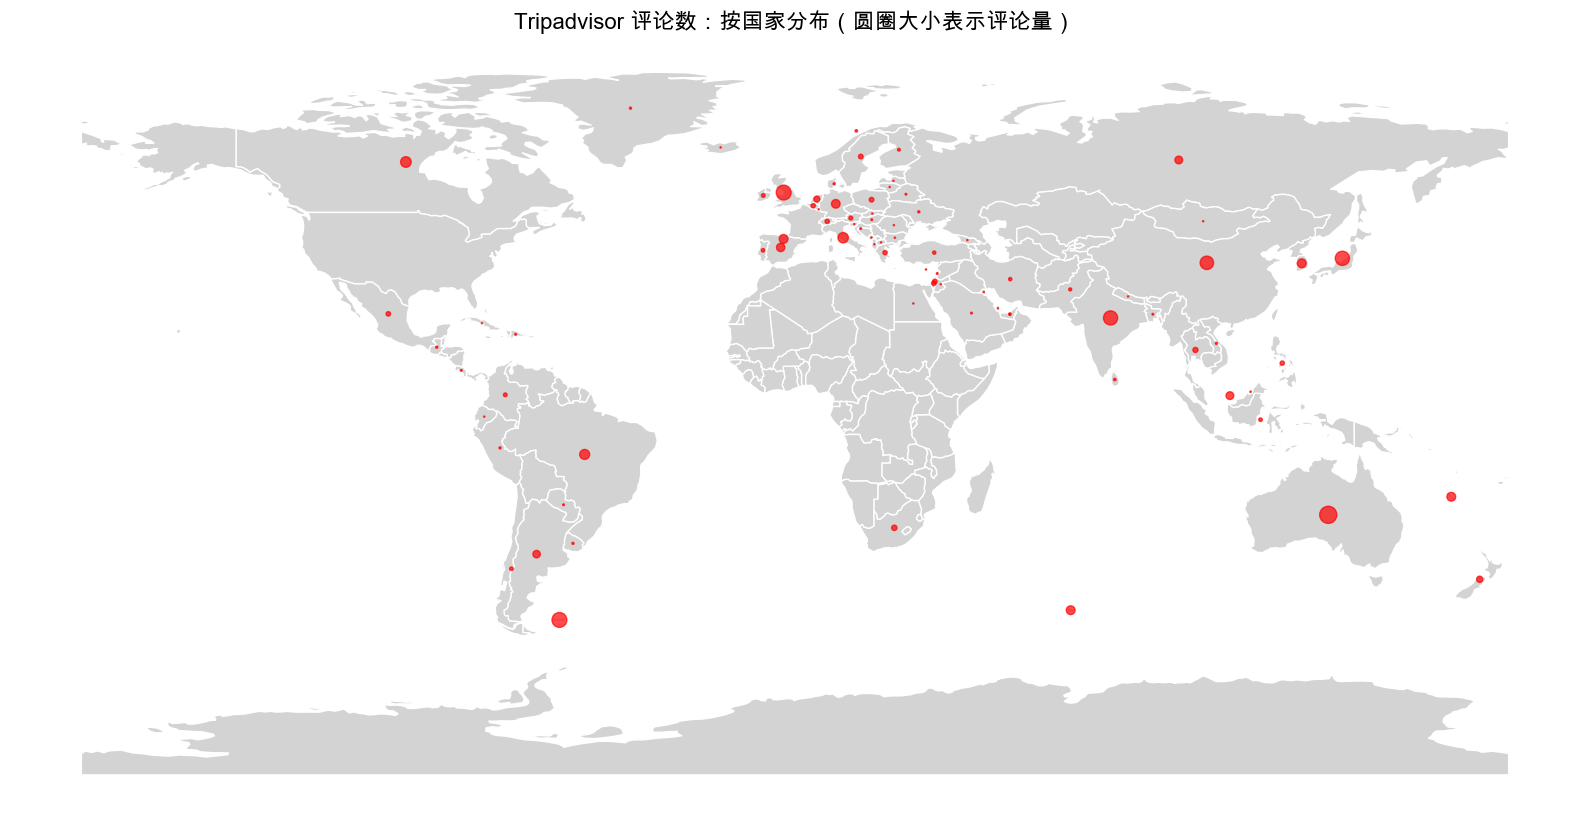

In [12]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# 设置中文字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS']
matplotlib.rcParams['axes.unicode_minus'] = False

# 1. 读取国家统计数据
df = pd.read_csv('/Users/elsa/Desktop/爬虫学习/0704学习/国家为单位统计.csv')

# 2. 读取世界地图
world = gpd.read_file('/Users/elsa/Desktop/爬虫学习/0704学习/naturalearth_lowres/ne_110m_admin_0_countries.shp')

# 3. 合并数据（英文国名 <-> SOVEREIGNT）
merged = world.merge(df, left_on='SOVEREIGNT', right_on='英文国名', how='left')

# 4. 取每个国家的几何中心
merged['centroid'] = merged.geometry.centroid

# 5. 只保留有“人数”数据的国家
plot_df = merged.dropna(subset=['人数'])

# 6. 构建GeoDataFrame用于画点
gdf = gpd.GeoDataFrame(plot_df, geometry='centroid')

# 7. 绘图
fig, ax = plt.subplots(figsize=(16, 9))
world.plot(ax=ax, color='lightgrey', edgecolor='white')
gdf.plot(ax=ax, markersize=gdf['人数'] * 0.8, color='red', alpha=0.7)

'''
# 8. 添加标签（可选，人数较多时建议注释掉）
for idx, row in gdf.iterrows():
    plt.text(row.centroid.x, row.centroid.y, f"{row['国家']}\n{int(row['人数'])}",
             ha='center', fontsize=8, fontweight='bold')
'''

ax.set_title("Tripadvisor 评论数：按国家分布（圆圈大小表示评论量）", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## 生成html地图

In [13]:
import geopandas as gpd
import pandas as pd
import folium

# 1. 读取国家统计数据
df = pd.read_csv('/Users/elsa/Desktop/爬虫学习/0704学习/国家为单位统计.csv')

# 2. 读取世界地图
world = gpd.read_file('/Users/elsa/Desktop/爬虫学习/0704学习/naturalearth_lowres/ne_110m_admin_0_countries.shp')

# 3. 合并数据（英文国名 <-> SOVEREIGNT）
merged = world.merge(df, left_on='SOVEREIGNT', right_on='英文国名', how='left')

# 4. 取每个国家的几何中心
merged['centroid'] = merged.geometry.centroid

# 5. 只保留有“人数”数据的国家
plot_df = merged.dropna(subset=['人数'])

# 6. 创建folium地图（以世界中心为例）
m = folium.Map(location=[20, 0], zoom_start=2)

# 7. 添加红点和悬停提示
for idx, row in plot_df.iterrows():
    lon, lat = row['centroid'].x, row['centroid'].y
    folium.CircleMarker(
        location=[lat, lon],
        radius=max(row['人数'] * 0.05, 3),  # 点大小可调
        color='red',
        fill=True,
        fill_opacity=0.7,
        popup=f"{row['国家']}<br>人数: {int(row['人数'])}",
        tooltip=row['国家']  # 鼠标悬停显示国家名
    ).add_to(m)

# 8. 保存为HTML
m.save('/Users/elsa/Desktop/爬虫学习/0704学习/国家分布交互地图.html')
print("✅ 已生成交互式HTML地图！")

✅ 已生成交互式HTML地图！


/var/folders/74/vvf36t8x5d54mt560fvxnn3r0000gn/T/ipykernel_26298/1973518231.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid
